In this note book we share our best results on text sentiment analysis on Tweets collected from approximately 10k users

---
We used regex and numpy and sklearn for Preprocessing \\
We mainly used Tensorflow and Keras and transformers for building our model and training process \\ 
For fast training this paper should be executed on TPU(google colab or etc)


# Get Dataset

In [ ]:
!wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
!unzip DSL2122_january_dataset.zip

# Import required libraries

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import re
!pip install transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tensorflow_hub as hub
!pip install sentencepiece
import tokenization
import tensorflow as tf
import os

# Preview of Dataset

In [3]:
dataframe = pd.read_csv('/content/DSL2122_january_dataset/development.csv')
dataframe

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...
...,...,...,...,...,...,...
224989,0,2261324310,Sat Jun 20 20:36:48 PDT 2009,NO_QUERY,CynthiaBuroughs,@Dropsofreign yeah I hope Iran people reach fr...
224990,1,1989408152,Mon Jun 01 01:25:45 PDT 2009,NO_QUERY,unitechy,Trying the qwerty keypad
224991,0,1991221316,Mon Jun 01 06:38:10 PDT 2009,NO_QUERY,Xaan,I love Jasper &amp; Jackson but that wig in th...
224992,0,2239702807,Fri Jun 19 08:51:56 PDT 2009,NO_QUERY,Ginger_Billie,I am really tired and bored and bleh! I feel c...


# Analyzing Dataset

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


# Preprocessing

In [ ]:
""" Some Examples """

print(dataframe['text'][63])
# In this case one word is non English

print(dataframe['text'][51])
# In this case we have @id + website

print(dataframe['text'][149])
# In this case word [-O] is not a word


""" So many cases exist in the dataset like cases above and needs to be cleaned """

@Md8oz that hurt  ã?³ just fucked me harddddd lol
@HOTTVampChick here you go  http://bit.ly/qNtRH
[-O] Just got off work getting ready to leave for INDPLS 500 mini-marathon. Wish me luck.  http://tinyurl.com/cnn45k


' So many cases exist in the dataset like cases above and needs to be cleaned '

In [ ]:
texts = dataframe['text']
sentiments = dataframe['sentiment']

new_texts = []

for i in range(len(texts)):
  text = texts[i].lower()
  # Replace URLs with a space in the message
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)

  # Remove non english words
  tmp = []
  words = text.split()
  for i in range(len(words)):
    word = words[i]
    has_non_ascii = False
    for char in word:
      if ord(char) > 127:
        has_non_ascii = True
        break
    if not has_non_ascii:
      tmp.append(word)
  text = ' '.join([w for w in tmp])

 

  new_texts.append(text)



In [ ]:
# Find maximum lenght of tweet for tokenizer
maxLen = 0
for text in new_texts:
  if len(text) > maxLen:
    print(text)
    maxLen = len(text)

print("Max lenght of a tweet has ",maxLen," words")

@missbianca76 yes, talking helps a lot.. going through it, there's no judgment... most sentences end with &quot;you know what i mean&quot;
@the_wockeez i wanna say thanks for brining hiphop to a nkotb show. i'm a hiphop junkie &amp; loose my mind when y'all hit the stage!! thanks
@dave_annable b&amp;s is in my netflix queue &amp; i should receive the first dvd mon. can't wait to watch it &amp; give a full review - ebert style!
think &quot;mental&quot; is some kind of copy of house m.d.. they even have their own &quot;cuddy&quot;.. not impressed at all you copy house-you fail!
i am soooo saying this phrase now &quot;stop be so false&quot; thanks to some @aliciaway &quot;hater&quot;/yoda person! goodnight and stop be so false!!
&quot;hey, natalie!&quot; &quot;what?&quot; &quot;....what? i didn't say anything.&quot; &quot;fuck off.&quot; ...just another wonderful conversation with my sis
hate hate hate admin - my admin file labels read &quot;boring stuff 1&quot; &quot;bs 2&quot; &quot;stu

# Load BERT layer for preprocessing

In [ ]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.


# Tokenize Tweets

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)      # Token vector
        all_masks.append(pad_masks)    # Mask vector
        all_segments.append(segment_ids)  # Segment Vector
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# Split Validation and Test

In [ ]:
""" While trying to find best model we used test_size = 0.15 ; however; for getting the best results we used 99% of data for training """  
train_input ,val_input,train_y,val_y = train_test_split(new_texts,np.array(sentiments),test_size = .01,stratify=np.array(sentiments),random_state = 0)
train_x = bert_encode(train_input, tokenizer, max_len=maxLen)
val_x = bert_encode(val_input, tokenizer, max_len=maxLen)
train_y = train_y.astype('float32').reshape((-1,1))
val_y = val_y.astype('float32').reshape((-1,1))


# Building model

In [ ]:
def build_model(max_len=140):
    encoder = TFBertModel.from_pretrained("bert-base-uncased")   #Bert base pre-trained model 
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    clf_output = encoder([input_word_ids, input_mask, segment_ids])[0][:,0,:]

    # Our classifier 
    net = tf.keras.layers.Dropout(0.3)(clf_output)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(2, activation='softmax')(net)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-08)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(loss=loss,optimizer=optimizer,metrics=[metric])  


    
    return model

# Build model in TPU in order to fast training

In [ ]:
# Create distribution strategy
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

# Model Summary

In [ ]:
with strategy.scope():
 model= build_model(max_len=maxLen)
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 174)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 174)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 174)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

# Training

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True, verbose=1)

train_history = model.fit(train_x, train_y,validation_data = [val_x,val_y],validation_batch_size = 64,epochs=1,callbacks=[checkpoint],batch_size=32,verbose=1)

6961/6961 [==============================] - ETA: 0s - loss: 0.3140 - sparse_categorical_accuracy: 0.8658
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.86178, saving model to model.h5
6961/6961 [==============================] - 646s 93ms/step - loss: 0.3140 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.3213 - val_sparse_categorical_accuracy: 0.8618 - lr: 1.0000e-05


# Plot training

In [ ]:
# For 2 epochs we do not need to plot training process
def plot_acc(history, title = 'Accuracy'):
    plt.figure(figsize=(15,10))
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['sparse_categorical_accuracy'])
    plt.plot(history['val_sparse_categorical_accuracy'])
    if title is not None:
        plt.title(title)

    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

def plot_loss(history, title = 'loss'):
    plt.figure(figsize=(15,10))
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)

plot_loss(train_history)
plot_acc(train_history)

# Evaluate Model

In [ ]:
# Load the best model an evaluate on our little validation
model.load_weights('model.h5')
predictions = model.predict(val_x)
target_names = ['Negative', 'Positive']
print(classification_report(val_y, np.argmax(predictions,axis = 1), target_names=target_names))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 174) dtype=int64>]


              precision    recall  f1-score   support

    Negative       0.86      0.80      0.83       948
    Positive       0.86      0.91      0.89      1302

    accuracy                           0.86      2250
   macro avg       0.86      0.86      0.86      2250
weighted avg       0.86      0.86      0.86      2250



# Confusion matrix on validation 

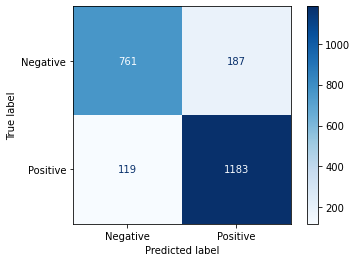

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = val_y,y_pred = np.argmax(predictions,axis = 1), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(cmap = "Blues")

# Test on Evaluation DataSet 

In [ ]:
# Do the same preprocessing for Test dataset

test_dataframe = pd.read_csv('/content/DSL2122_january_dataset/evaluation.csv')
texts = test_dataframe['text']


new_texts = []


for i in range(len(texts)):
  text = texts[i].lower()
  # Replace URLs with a space in the message
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)

  # Remove stop words
  tmp = []
  words = text.split()
  for i in range(len(words)):
    word = words[i]
    has_non_ascii = False
    for char in word:
      if ord(char) > 127:
        has_non_ascii = True
        break
    if not has_non_ascii:
      tmp.append(word)
  text = ' '.join([w for w in tmp])

  

  new_texts.append(text)
  



# Predict on test dataset and make submission csv

In [ ]:
test_input = bert_encode(new_texts, tokenizer, max_len=maxLen)
p = model.predict(test_input)
p = np.argmax(p,axis = 1)

In [ ]:
submission_csv = pd.read_csv('/content/DSL2122_january_dataset/sample_submission.csv')

submission_csv['Predicted'] = p
submission_csv.to_csv('submission.csv',index =False)